Use recipes from the RAW_recipes.csv dataset downloaded from https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions?select=RAW_recipes.csv

In [49]:
import json
import pandas as pd
import numpy as np
from wordcloud import WordCloud

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
import gensim
from gensim import models
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
from tqdm import tqdm
from textblob import TextBlob
import json
import re
import spacy
import matplotlib.pyplot as plt
import ast
import glob

from multiprocessing import Pool

In [2]:
%%time
recipe_df = pd.read_csv('/content/drive/MyDrive/Analytics/GCPLP/Data/RAW_recipes.csv')

CPU times: user 6.7 s, sys: 641 ms, total: 7.34 s
Wall time: 18.1 s


In [3]:
recipe_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [4]:
recipe_df.shape

(231637, 12)

In [5]:
# drop the columns that are not needed
recipe_df.drop({'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'description', 'n_ingredients'}, axis=1, inplace=True)

In [7]:
# check for any null values
recipe_df.isnull().sum(axis=0)

name           1
steps          0
ingredients    0
dtype: int64

In [8]:
# remove rows with null values
recipe_df = recipe_df.dropna()

recipe_df.shape

(231636, 3)

In [9]:
# function to generate wordcloud
def min_wordcloud(df, column):
    text = str(df[column].values)
    wordcloud = WordCloud().generate(text)
    image = wordcloud.to_image()
    return image

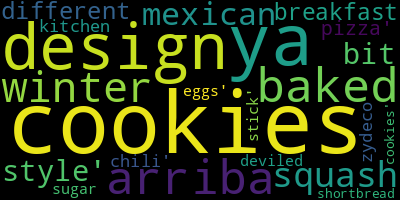

In [10]:
min_wordcloud(recipe_df,'name')

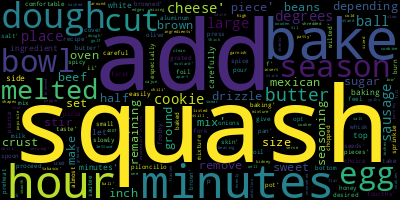

In [11]:
min_wordcloud(recipe_df,'steps')

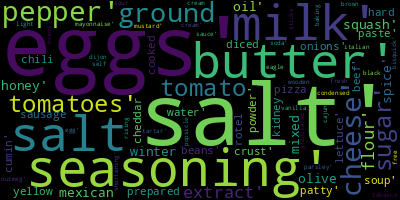

In [12]:
min_wordcloud(recipe_df,'ingredients')

Read in webscraped data and merge with existing dataset

In [13]:
DATA_PATH = '/content/drive/MyDrive/Analytics/GCPLP/Data/data*.json'

json_files = glob.glob(DATA_PATH)

data = []

filename = 'allrecipies.csv'

In [14]:
for jf in json_files:
    with open(jf, 'r', encoding = 'utf-8') as f:
        json_file = json.load(f)
        data.append([json_file['title'], json_file['instructions_list'], json_file['ingredients']])

In [15]:
webscrape_df = pd.DataFrame(data, columns=['name', 'steps', 'ingredients'])
webscrape_df

,name,steps,ingredients
0,Singapore Fried Noodles,"[PREPARATION., Boil noodles until cooked but s...","[1 package chow mein noodles, 10 large cooked ..."
1,Singapore Chilli Prawns (Shrimp),[Heat oil and stir fry prawns until they chang...,"[2 tablespoons oil, 500 g green prawns (uncook..."
2,Coconut Curd | Kaya(Singapore),"[Whisk the sugar, yolks and coconut milk and t...",[1 (13 1/2 ounce) can coconut milk (not light)...
3,Singapore Sling Slush,"[Mix all ingredients except 7-up., Place in fr...","[12 ounces gin, 1/2 cup cherry brandy, 1/2 cup..."
4,Crispy Oven-roasted Pork Recipe,[Wash and clean pork thoroughly under running ...,"[1 pork belly with skin, ½ tsp ground pepper, ..."
...,...,...,...
102,Singapore Sling,[Add the first 3 ingredients to a cocktail sha...,"[1 1/3 ounces gin, 2/3 ounce cherry brandy, 1/..."
103,Spaghetti Bolognese With Tomato Chicken Sauce,"[For tomato sauce:, peel tomatoes, Make “x” cu...","[1.2 kg tomatoes, 1 tsp fine salt, 2 tbsps sug..."
104,Singapore Black Pepper Crab Sauce,"[Combine oyster sauce, sugar, water, and Kecap...","[1/2 cup oyster sauce, 1/2 cup granulated suga..."
105,Crispy Deep-fried Dried Anchovies (Ikan Bilis),[Rinse the cleaned anchovies 3 times to remove...,[100 g dried anchovies (heads & intestines rem...


In [16]:
# save data to csv file
webscrape_df.to_csv('/content/drive/MyDrive/Analytics/GCPLP/Data/all_recipes.csv', index=False)

In [17]:
# read in the webscrape data
webscrape_df = pd.read_csv('/content/drive/MyDrive/Analytics/GCPLP/Data/all_recipes.csv')
webscrape_df

,name,steps,ingredients
0,Singapore Fried Noodles,"['PREPARATION.', 'Boil noodles until cooked bu...","['1 package chow mein noodles', '10 large cook..."
1,Singapore Chilli Prawns (Shrimp),['Heat oil and stir fry prawns until they chan...,"['2 tablespoons oil', '500 g green prawns (unc..."
2,Coconut Curd | Kaya(Singapore),"['Whisk the sugar, yolks and coconut milk and ...",['1 (13 1/2 ounce) can coconut milk (not light...
3,Singapore Sling Slush,"['Mix all ingredients except 7-up.', 'Place in...","['12 ounces gin', '1/2 cup cherry brandy', '1/..."
4,Crispy Oven-roasted Pork Recipe,['Wash and clean pork thoroughly under running...,"['1 pork belly with skin', '½ tsp ground peppe..."
...,...,...,...
102,Singapore Sling,['Add the first 3 ingredients to a cocktail sh...,"['1 1/3 ounces gin', '2/3 ounce cherry brandy'..."
103,Spaghetti Bolognese With Tomato Chicken Sauce,"['For tomato sauce:', 'peel tomatoes', 'Make “...","['1.2 kg tomatoes', '1 tsp fine salt', '2 tbsp..."
104,Singapore Black Pepper Crab Sauce,"['Combine oyster sauce, sugar, water, and Keca...","['1/2 cup oyster sauce', '1/2 cup granulated s..."
105,Crispy Deep-fried Dried Anchovies (Ikan Bilis),['Rinse the cleaned anchovies 3 times to remov...,['100 g dried anchovies (heads & intestines re...


In [18]:
# append to existing df
recipe_df = recipe_df.append(webscrape_df, ignore_index=True)
recipe_df

<ipython-input-18-f0a9a1a09b55>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recipe_df = recipe_df.append(webscrape_df, ignore_index=True)


,name,steps,ingredients
0,arriba baked winter squash mexican style,"['make a choice and proceed with recipe', 'dep...","['winter squash', 'mexican seasoning', 'mixed ..."
1,a bit different breakfast pizza,"['preheat oven to 425 degrees f', 'press dough...","['prepared pizza crust', 'sausage patty', 'egg..."
2,all in the kitchen chili,"['brown ground beef in large pot', 'add choppe...","['ground beef', 'yellow onions', 'diced tomato..."
3,alouette potatoes,['place potatoes in a large pot of lightly sal...,"['spreadable cheese with garlic and herbs', 'n..."
4,amish tomato ketchup for canning,['mix all ingredients& boil for 2 1 / 2 hours ...,"['tomato juice', 'apple cider vinegar', 'sugar..."
...,...,...,...
231738,Singapore Sling,['Add the first 3 ingredients to a cocktail sh...,"['1 1/3 ounces gin', '2/3 ounce cherry brandy'..."
231739,Spaghetti Bolognese With Tomato Chicken Sauce,"['For tomato sauce:', 'peel tomatoes', 'Make “...","['1.2 kg tomatoes', '1 tsp fine salt', '2 tbsp..."
231740,Singapore Black Pepper Crab Sauce,"['Combine oyster sauce, sugar, water, and Keca...","['1/2 cup oyster sauce', '1/2 cup granulated s..."
231741,Crispy Deep-fried Dried Anchovies (Ikan Bilis),['Rinse the cleaned anchovies 3 times to remov...,['100 g dried anchovies (heads & intestines re...


Number the Steps

In [19]:
for ind in recipe_df.index:
  modified_list = []

  for i, value in enumerate(ast.literal_eval(recipe_df.iloc[ind][1]), start=1):
    modified_list.append(f'{i}) {value}')

  #print (' '.join(modified_list))
  val = ' '.join(modified_list)
  recipe_df.at[ind, 'combined_steps'] = val

In [20]:
for ind in recipe_df.index:
  modified_list = []

  modified_list.append(ast.literal_eval(recipe_df.iloc[ind][2]))

  result = ''.join(', '.join(l) for l in modified_list)
  recipe_df.at[ind, 'combined_ingredients'] = result

In [21]:
#Prepare title of food
recipe_df.name = recipe_df.name.str.title()
recipe_df['name'] = recipe_df['name'].str.replace(r'\s+', ' ', regex=True)

In [22]:
for ind in recipe_df.index:

  try:
    result = recipe_df.iloc[ind][0] + ' ' +  'Steps: ' + recipe_df.iloc[ind][3] + ' ' +   'Ingredients: ' +recipe_df.iloc[ind][4]
  except Exception as e:
    print(f"Error processing row : {e}")

  recipe_df.at[ind, 'combined_recipe'] = result

In [23]:
recipe_df

,name,steps,ingredients,combined_steps,combined_ingredients,combined_recipe
0,Arriba Baked Winter Squash Mexican Style,"['make a choice and proceed with recipe', 'dep...","['winter squash', 'mexican seasoning', 'mixed ...",1) make a choice and proceed with recipe 2) de...,"winter squash, mexican seasoning, mixed spice,...",Arriba Baked Winter Squash Mexican Style Steps...
1,A Bit Different Breakfast Pizza,"['preheat oven to 425 degrees f', 'press dough...","['prepared pizza crust', 'sausage patty', 'egg...",1) preheat oven to 425 degrees f 2) press doug...,"prepared pizza crust, sausage patty, eggs, mil...",A Bit Different Breakfast Pizza Steps: 1) preh...
2,All In The Kitchen Chili,"['brown ground beef in large pot', 'add choppe...","['ground beef', 'yellow onions', 'diced tomato...",1) brown ground beef in large pot 2) add chopp...,"ground beef, yellow onions, diced tomatoes, to...",All In The Kitchen Chili Steps: 1) brown groun...
3,Alouette Potatoes,['place potatoes in a large pot of lightly sal...,"['spreadable cheese with garlic and herbs', 'n...",1) place potatoes in a large pot of lightly sa...,"spreadable cheese with garlic and herbs, new p...",Alouette Potatoes Steps: 1) place potatoes in ...
4,Amish Tomato Ketchup For Canning,['mix all ingredients& boil for 2 1 / 2 hours ...,"['tomato juice', 'apple cider vinegar', 'sugar...",1) mix all ingredients& boil for 2 1 / 2 hours...,"tomato juice, apple cider vinegar, sugar, salt...",Amish Tomato Ketchup For Canning Steps: 1) mix...
...,...,...,...,...,...,...
231738,Singapore Sling,['Add the first 3 ingredients to a cocktail sh...,"['1 1/3 ounces gin', '2/3 ounce cherry brandy'...",1) Add the first 3 ingredients to a cocktail s...,"1 1/3 ounces gin, 2/3 ounce cherry brandy, 1/2...",Singapore Sling Steps: 1) Add the first 3 ingr...
231739,Spaghetti Bolognese With Tomato Chicken Sauce,"['For tomato sauce:', 'peel tomatoes', 'Make “...","['1.2 kg tomatoes', '1 tsp fine salt', '2 tbsp...",1) For tomato sauce: 2) peel tomatoes 3) Make ...,"1.2 kg tomatoes, 1 tsp fine salt, 2 tbsps suga...",Spaghetti Bolognese With Tomato Chicken Sauce ...
231740,Singapore Black Pepper Crab Sauce,"['Combine oyster sauce, sugar, water, and Keca...","['1/2 cup oyster sauce', '1/2 cup granulated s...","1) Combine oyster sauce, sugar, water, and Kec...","1/2 cup oyster sauce, 1/2 cup granulated sugar...",Singapore Black Pepper Crab Sauce Steps: 1) Co...
231741,Crispy Deep-Fried Dried Anchovies (Ikan Bilis),['Rinse the cleaned anchovies 3 times to remov...,['100 g dried anchovies (heads & intestines re...,1) Rinse the cleaned anchovies 3 times to remo...,100 g dried anchovies (heads & intestines remo...,Crispy Deep-Fried Dried Anchovies (Ikan Bilis)...


Prep data for topic modelling

In [40]:
# import default stopwords
sp = spacy.load('en_core_web_sm')
stopwords = sp.Defaults.stop_words

# add stopwords "step" and "ingredient" since we introduced them earlier on
stopwords.add('step')
stopwords.add('ingredient')
# add units into stopwords
stopwords.add('oz')
stopwords.add('ounc')
stopwords.add('ounce')
stopwords.add('pound')
stopwords.add('lb')
stopwords.add('inch')
stopwords.add('kg')
stopwords.add('g')
stopwords.add('cup')
stopwords.add('tsp')
stopwords.add('tablespoon')
stopwords.add('teaspoon')

In [41]:
# function to lemmatize, filter stopwords, remove non-letters, convert to lower case
def spacy_process(text):
    doc = sp(text)

# Lemmatization with Spacy
    lemma_list = []
    for token in doc:
        lemma_list.append(token.lemma_)

    # Filter the stopwords, remove non-letters and lower case
    filtered_sentence =[]
    for word in lemma_list:
        lexeme = sp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
    lower_words = []
    for word in filtered_sentence:
        text_letters_only = re.sub("[^a-zA-Z]", " ", word)
        text_words_lower = text_letters_only.lower()
        lower_words.append(text_words_lower)
    text_final = " ".join(lower_words)
    return  " ".join(text_final.split())

In [42]:
# concatenate the title, ingredients and steps into a single text field, then apply the function on it
all_text = recipe_df['name'] + ' ' + recipe_df['ingredients'] + ' ' + recipe_df['steps']
all_text[231742]

"Singapore Black Pepper Crab ['3 tablespoons ketjap manis', '3 tablespoons oyster sauce', '3 tablespoons caster sugar', '2 kg raw blue swimmer crabs', '1 1/2 tablespoons oil', '1 1/2 tablespoons butter', '1 1/2 tablespoons grated fresh ginger', '6 garlic cloves, finely chopped', '1 -2 red chile, finely chopped', '1 1/2 tablespoons black pepper', '1 1/2 teaspoons white pepper', '1/4 teaspoon ground coriander', '2 spring onions, finely chopped', '1/4 cup chopped fresh coriander'] ['Put kecap manis, oyster sauce, sugar and 3 tablespoons water in a small bowl, stir, then set aside.', 'Pull back the apron of each crab, remove top shell, then intestines and feathery gills. Rinse quickly.', 'Cut each crab into quarters and crack the legs gently (I use a meat mallet) so the flavours can enter.', 'Heat the oil in a very large wok over high heat; add the crab pieces and stir fry in batches until the shell is bright orange and the meat almost cooked (about 5 minutes). Remove and repeat until all 

In [43]:
spacy_process(all_text[231742])

'singapore black pepper crab ketjap manis oyster sauce caster sugar raw blue swimmer crab oil butter grate fresh ginger garlic clove finely chop red chile finely chop black pepper white pepper ground coriander spring onion finely chop chop fresh coriander kecap manis oyster sauce sugar water small bowl stir set aside pull apron crab remove shell intestine feathery gill rinse quickly cut crab quarter crack leg gently use meat mallet flavour enter heat oil large wok high heat add crab piece stir fry batch shell bright orange meat cook minute remove repeat cook add butter ginger garlic chilli black white pepper coriander wok stir fry second add sauce mixture stir bring boil simmer minute return crab wok toss coat sauce cook minute finish cook crab garnish spring onion coriander leave serve'

In [44]:
%%time

# create a new column to save the processed text
recipe_df['cleaned_text'] = all_text.apply(spacy_process)

CPU times: user 2h 29min 50s, sys: 20.2 s, total: 2h 30min 11s
Wall time: 2h 31min 29s


In [45]:
recipe_df['cleaned_text']

0         arriba baked winter squash mexican style winte...
1         bit different breakfast pizza prepared pizza c...
2         kitchen chili ground beef yellow onion diced t...
3         alouette potatoes spreadable cheese garlic her...
4         amish tomato ketchup canning tomato juice appl...
                                ...                        
231738    singapore sling gin cherry brandy fresh squeez...
231739    spaghetti bolognese tomato chicken sauce tomat...
231740    singapore black pepper crab sauce oyster sauce...
231741    crispy deep fried dried anchovies ikan bilis d...
231742    singapore black pepper crab ketjap manis oyste...
Name: cleaned_text, Length: 231743, dtype: object

In [46]:
%%time

# create a new column for the cleaned ingredients
recipe_df['cleaned_ingredients'] = recipe_df['ingredients'].apply(spacy_process)

CPU times: user 1h 2min 22s, sys: 10.6 s, total: 1h 2min 32s
Wall time: 1h 3min 9s


In [47]:
recipe_df['cleaned_ingredients']

0         winter squash mexican season mixed spice honey...
1         prepared pizza crust sausage patty egg milk sa...
2         ground beef yellow onion diced tomato tomato p...
3         spreadable cheese garlic herb new potato shall...
4         tomato juice apple cider vinegar sugar salt pe...
                                ...                        
231738    gin cherry brandy fresh squeeze lemon juice cl...
231739    tomatoe fine salt tbsps sugar tbsp dry mixed h...
231740    oyster sauce granulate sugar water ketjap mani...
231741     dry anchovy head intestine remove ml cooking oil
231742    ketjap manis oyster sauce caster sugar raw blu...
Name: cleaned_ingredients, Length: 231743, dtype: object

In [48]:
# save processed data to csv file
recipe_df.to_csv('/content/drive/MyDrive/Analytics/GCPLP/Data/cleaned_recipes.csv', index=False)

NOTE: Run GCPLP_data_prep_cuisine.ipynb for further processing and to add in the cuisine before proceeding.

In [50]:
# read in the pre-processed data
recipe_df = pd.read_csv('/content/drive/MyDrive/Analytics/GCPLP/Data/cleaned_recipes_cuisine.csv')

Tokenizing

In [51]:
# tokenise each recipe into individual words in a list
recipe_df['tokenised_text'] = [r.split() for r in recipe_df['cleaned_text']]

In [52]:
# tokenise each ingredient into individual words in a list
recipe_df['tokenised_ingredients'] = [r.split() for r in recipe_df['cleaned_ingredients']]

In [53]:
recipe_df

,name,steps,ingredients,combined_steps,combined_ingredients,combined_recipe,cleaned_text,cleaned_ingredients,cuisine,tokenised_text,tokenised_ingredients
0,Arriba Baked Winter Squash Mexican Style,"['make a choice and proceed with recipe', 'dep...","['winter squash', 'mexican seasoning', 'mixed ...",1) make a choice and proceed with recipe 2) de...,"winter squash, mexican seasoning, mixed spice,...",Arriba Baked Winter Squash Mexican Style Steps...,arriba baked winter squash mexican style winte...,winter squash mexican season mixed spice honey...,mexican,"[arriba, baked, winter, squash, mexican, style...","[winter, squash, mexican, season, mixed, spice..."
1,A Bit Different Breakfast Pizza,"['preheat oven to 425 degrees f', 'press dough...","['prepared pizza crust', 'sausage patty', 'egg...",1) preheat oven to 425 degrees f 2) press doug...,"prepared pizza crust, sausage patty, eggs, mil...",A Bit Different Breakfast Pizza Steps: 1) preh...,bit different breakfast pizza prepared pizza c...,prepared pizza crust sausage patty egg milk sa...,italian,"[bit, different, breakfast, pizza, prepared, p...","[prepared, pizza, crust, sausage, patty, egg, ..."
2,All In The Kitchen Chili,"['brown ground beef in large pot', 'add choppe...","['ground beef', 'yellow onions', 'diced tomato...",1) brown ground beef in large pot 2) add chopp...,"ground beef, yellow onions, diced tomatoes, to...",All In The Kitchen Chili Steps: 1) brown groun...,kitchen chili ground beef yellow onion diced t...,ground beef yellow onion diced tomato tomato p...,mexican,"[kitchen, chili, ground, beef, yellow, onion, ...","[ground, beef, yellow, onion, diced, tomato, t..."
3,Alouette Potatoes,['place potatoes in a large pot of lightly sal...,"['spreadable cheese with garlic and herbs', 'n...",1) place potatoes in a large pot of lightly sa...,"spreadable cheese with garlic and herbs, new p...",Alouette Potatoes Steps: 1) place potatoes in ...,alouette potatoes spreadable cheese garlic her...,spreadable cheese garlic herb new potato shall...,french,"[alouette, potatoes, spreadable, cheese, garli...","[spreadable, cheese, garlic, herb, new, potato..."
4,Amish Tomato Ketchup For Canning,['mix all ingredients& boil for 2 1 / 2 hours ...,"['tomato juice', 'apple cider vinegar', 'sugar...",1) mix all ingredients& boil for 2 1 / 2 hours...,"tomato juice, apple cider vinegar, sugar, salt...",Amish Tomato Ketchup For Canning Steps: 1) mix...,amish tomato ketchup canning tomato juice appl...,tomato juice apple cider vinegar sugar salt pe...,southern_us,"[amish, tomato, ketchup, canning, tomato, juic...","[tomato, juice, apple, cider, vinegar, sugar, ..."
...,...,...,...,...,...,...,...,...,...,...,...
231738,Singapore Sling,['Add the first 3 ingredients to a cocktail sh...,"['1 1/3 ounces gin', '2/3 ounce cherry brandy'...",1) Add the first 3 ingredients to a cocktail s...,"1 1/3 ounces gin, 2/3 ounce cherry brandy, 1/2...",Singapore Sling Steps: 1) Add the first 3 ingr...,singapore sling gin cherry brandy fresh squeez...,gin cherry brandy fresh squeeze lemon juice cl...,spanish,"[singapore, sling, gin, cherry, brandy, fresh,...","[gin, cherry, brandy, fresh, squeeze, lemon, j..."
231739,Spaghetti Bolognese With Tomato Chicken Sauce,"['For tomato sauce:', 'peel tomatoes', 'Make “...","['1.2 kg tomatoes', '1 tsp fine salt', '2 tbsp...",1) For tomato sauce: 2) peel tomatoes 3) Make ...,"1.2 kg tomatoes, 1 tsp fine salt, 2 tbsps suga...",Spaghetti Bolognese With Tomato Chicken Sauce ...,spaghetti bolognese tomato chicken sauce tomat...,tomatoe fine salt tbsps sugar tbsp dry mixed h...,italian,"[spaghetti, bolognese, tomato, chicken, sauce,...","[tomatoe, fine, salt, tbsps, sugar, tbsp, dry,..."
231740,Singapore Black Pepper Crab Sauce,"['Combine oyster sauce, sugar, water, and Keca...","['1/2 cup oyster sauce', '1/2 cup granulated s...","1) Combine oyster sauce, sugar, water, and Kec...","1/2 cup oyster sauce, 1/2 cup granulated sugar...",Singapore Black Pepper Crab Sauce Steps: 

In [54]:
# save processed data to csv file
recipe_df.to_csv('/content/drive/MyDrive/Analytics/GCPLP/Data/tokenised_recipes.csv', index=False)

Topic Modelling

In [ ]:
# read in the pre-processed data
recipe_df = pd.read_csv('/content/drive/MyDrive/Analytics/GCPLP/Data/tokenised_recipes.csv')

NameError: ignored

In [ ]:
dictionary = gensim.corpora.Dictionary(recipe_df['tokenised_text'])

In [ ]:
# create the document term matrix from our dictionary of words from the titles
dtm = [dictionary.doc2bow(doc) for doc in recipe_df['tokenised_text']]

In [ ]:
# Creating the object for LDA model using gensim library
%%time
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=dtm, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

KeyboardInterrupt: ignored

In [ ]:
# Creating the object for LDA model using gensim library - try for 50 topics
%%time
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model_50 = LDA(corpus=dtm, id2word=dictionary, num_topics=50, random_state=100,
                chunksize=100, passes=50)

CPU times: user 6h 7min 13s, sys: 10min 54s, total: 6h 18min 7s
Wall time: 6h 9min 35s


In [ ]:
lda_model.print_topics()

In [ ]:
lda_model_50.print_topics()

[(14,
  '0.517*"butter" + 0.176*"melt" + 0.066*"microwave" + 0.054*"temperature" + 0.054*"room" + 0.027*"long" + 0.025*"second" + 0.023*"quarter" + 0.017*"tablespoon" + 0.013*"smooth"'),
 (32,
  '0.114*"bake" + 0.105*"oven" + 0.087*"minute" + 0.050*"dish" + 0.046*"preheat" + 0.041*"f" + 0.040*"degree" + 0.035*"place" + 0.033*"baking" + 0.032*"brown"'),
 (2,
  '0.172*"sauce" + 0.122*"mustard" + 0.111*"sugar" + 0.079*"vinegar" + 0.046*"cranberry" + 0.042*"dill" + 0.034*"combine" + 0.033*"berry" + 0.031*"ingredient" + 0.027*"ketchup"'),
 (0,
  '0.237*"corn" + 0.160*"cilantro" + 0.117*"pea" + 0.058*"taco" + 0.055*"avocado" + 0.054*"frozen" + 0.049*"chile" + 0.047*"cornmeal" + 0.031*"tomato" + 0.025*"kernel"'),
 (4,
  '0.168*"use" + 0.081*"time" + 0.069*"form" + 0.049*"knife" + 0.043*"need" + 0.039*"deep" + 0.034*"good" + 0.034*"color" + 0.031*"gently" + 0.027*"carefully"'),
 (15,
  '0.083*"oil" + 0.072*"rice" + 0.065*"add" + 0.059*"sauce" + 0.042*"minute" + 0.042*"fry" + 0.041*"heat" + 0.0

In [ ]:
#save model to file
lda_model.save('/content/drive/MyDrive/Analytics/GCPLP/Data/recipe_lda_model_topics')

In [ ]:
#save model to file
lda_model_50.save('/content/drive/MyDrive/Analytics/GCPLP/Data/recipe_lda_model_50_topics')

In [ ]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

#load model from file
lda_model = LDA.load('/content/drive/MyDrive/Analytics/GCPLP/Data/recipe_lda_model_topics')

In [ ]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

#load model for 50 topics from file
lda_model_50 = LDA.load('/content/drive/MyDrive/Analytics/GCPLP/Data/recipe_lda_model_50_topics')

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(dtm))
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=recipe_df['tokenised_text'], dictionary=dtm, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

NameError: ignored

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_50.log_perplexity(dtm))
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_50 = CoherenceModel(model=lda_model_50, texts=recipe_df['tokenised_text'], dictionary=dtm, coherence='c_v')
coherence_lda_50 = coherence_model_lda_50.get_coherence()
print('\nCoherence Score: ', coherence_lda_50)


Perplexity:  -12.555385684393913


AttributeError: ignored

In [ ]:
!pip install pyLDAvis
!pip install pandas==1.5.3
import pyLDAvis
import pyLDAvis.gensim_models
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 26.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.26.0 which is incompatible.
tensorflow 2.13.0 

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, dtm, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.138328 -0.057648       1        1  23.907117
4     -0.164422  0.071253       2        1  19.845719
2      0.106960 -0.151317       3        1  13.803045
3     -0.182550  0.145905       4        1  12.786249
5      0.162572  0.107638       5        1  10.028189
1      0.104129  0.096219       6        1   9.880917
6     -0.165017 -0.212050       7        1   9.748764, topic_info=        Term           Freq          Total Category  logprob  loglift
58    cheese  170543.000000  170543.000000  Default  30.0000  30.0000
292  chicken  109322.000000  109322.000000  Default  29.0000  29.0000
49     sugar  179436.000000  179436.000000  Default  28.0000  28.0000
72    pepper  232877.000000  232877.000000  Default  27.0000  27.0000
143   potato   70054.000000   70054.000000  Default  26.0000  26.0000
..       ...            ...            ...      ...      ...      ...
204  combine   12245.881309   98252.874603   Topic7  -4.9079   0.2457
246     cool   11539.453987   71762.911699   Topic7  -4.9673   0.5004
55      bowl   11440.832706  145621.311847   Topic7  -4.9759  -0.2158
207    fresh   10835.441775   87411.706698   Topic7  -5.0303   0.2402
209     heat   10953.745169  204562.949701   Topic7  -5.0194  -0.5992

[517 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
685       2  0.030447    accord
685       4  0.060658    accord
685       5  0.749845    accord
685       7  0.159079    accord
1395      2  0.999647    active
...     ...       ...       ...
1279      3  0.336321      zest
1279      7  0.663592      zest
3123      5  0.999340      ziti
521       1  0.128262  zucchini
521       5  0.871720  zucchini

[947 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 4, 6, 2, 7])

In [ ]:
# save visualisation
pyLDAvis.display(vis)
pyLDAvis.save_html(vis, '/content/drive/MyDrive/Analytics/GCPLP/Data/pyLDAvis.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Visualize the 50 topics
pyLDAvis.enable_notebook()
vis50 = pyLDAvis.gensim_models.prepare(lda_model_50, dtm, dictionary)
vis50

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
30     0.218041 -0.115506       1        1  9.877718
11     0.061251 -0.218296       2        1  5.891209
24     0.121097 -0.225933       3        1  5.685487
15     0.284575  0.001386       4        1  5.083983
32     0.074427 -0.238912       5        1  4.978130
44     0.282216  0.172544       6        1  3.956339
49     0.108148 -0.122261       7        1  3.955751
16     0.288520  0.158673       8        1  3.908043
10     0.185746  0.088310       9        1  2.866826
26     0.043982 -0.141971      10        1  2.798759
8      0.196725  0.046602      11        1  2.537436
18     0.173097  0.155579      12        1  2.458583
23     0.066989 -0.106032      13        1  2.440909
39    -0.039655 -0.025874      14        1  2.193339
36    -0.032634 -0.064646      15        1  2.189512
1      0.038636 -0.015804      16        1  2.130160
7      0.000705  0.057209      17        1  1.986157
28     0.028807 -0.173653      18        1  1.956954
21     0.137495  0.183309      19        1  1.833452
20    -0.031397  0.095658      20        1  1.693204
2      0.060903 -0.101163      21        1  1.625402
5      0.036811 -0.075880      22        1  1.604318
14    -0.128054  0.009226      23        1  1.571442
12    -0.034506 -0.066439      24        1  1.529468
31    -0.014968 -0.118412      25        1  1.437677
40     0.004323 -0.217834      26        1  1.355403
29    -0.085909 -0.061344      27        1  1.342033
3     -0.026837  0.003965      28        1  1.325420
4     -0.105629  0.004422      29        1  1.280617
43     0.048842  0.102725      30        1  1.276745
41    -0.003480 -0.017634      31        1  1.225288
33    -0.139501  0.001714      32        1  1.189616
13     0.145715  0.220348      33        1  1.154272
35    -0.013612 -0.049835      34        1  1.118599
22    -0.135827  0.022372      35        1  0.951334
45     0.030186  0.124834      36        1  0.947284
9     -0.138359  0.026728      37        1  0.922609
17    -0.154397  0.038864      38        1  0.879796
19    -0.110135 -0.009708      39        1  0.824790
27    -0.110366  0.025396      40        1  0.804857
0     -0.066141  0.097627      41        1  0.792536
34    -0.147070  0.022226      42        1  0.767489
47    -0.130446  0.062399      43        1  0.646126
38    -0.146217  0.071038      44        1  0.606059
6     -0.155496  0.058455      45        1  0.603934
46    -0.063185  0.070056      46        1  0.536797
48    -0.154017  0.045694      47        1  0.472198
37    -0.127193  0.037305      48        1  0.433335
42    -0.160552  0.075339      49        1  0.322617
25    -0.181655  0.087132      50        1  0.029987, topic_info=        Term           Freq          Total Category  logprob  loglift
58    cheese  186819.000000  186819.000000  Default  30.0000  30.0000
292  chicken  168219.000000  168219.000000  Default  29.0000  29.0000
4     butter  178764.000000  178764.000000  Default  28.0000  28.0000
30       oil  204368.000000  204368.000000  Default  27.0000  27.0000
62       egg  153699.000000  153699.000000  Default  26.0000  26.0000
..       ...            ...            ...      ...      ...      ...
25      melt       0.102717   58090.606497  Topic50 -10.8125  -5.1334
26   mexican       0.102717    2240.300512  Topic50 -10.8125  -1.8780
27    minute       0.102717  356079.702225  Topic50 -10.8125  -6.9465
28       mix       0.102717  166718.625254  Topic50 -10.8125  -6.1877
29     mixed       0.102717    8139.372016  Topic50 -10.8125  -3.1681

[2037 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
158      32  0.997634         a
685      46  0.999851    accord
820      31  0.996453      acid
86        1  0.263711       add
86        3  0.113835       add
...     ...       ...       ...
120      41  0.141311    yellow
608      34  0.999944    yogurt
492

In [ ]:
# save visualisation for the 50 topics
pyLDAvis.display(vis50)
pyLDAvis.save_html(vis50, '/content/drive/MyDrive/Analytics/GCPLP/Data/pyLDAvis_50.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Create Word Embeddings then do Topic Modelling - LDA & NNMF

In [ ]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(lowercase = True,
                            ngram_range = (1,1))

text_tfidf = vectorizer.fit_transform(recipe_df['tokenised_text'])
tfidf_words = vectorizer.get_feature_names_out()
print(text_tfidf.shape)
print(len(tfidf_words))

(226657, 49610)
49610


In [ ]:
text_tfidf.shape

(226657, 49610)

In [ ]:
#from sklearn.decomposition import LatentDirichletAllocation as LDA

#lda = LDA(n_components = 50,
#          n_jobs = -1,
#          max_iter = 100)
text_lda = lda_model.fit_transform(text_tfidf)
text_lda.shape

AttributeError: ignored

In [ ]:
from sklearn.decomposition import NMF

nmf = NMF(alpha_W=0.0,
         init='nndsvdar',
         l1_ratio=0.0,
         max_iter = 100,
         n_components = 50,
         solver='cd')

text_nmf = nmf.fit_transform(text_tfidf)
text_nmf.shape

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


(226657, 50)

In [ ]:
#save model to file
text_lda.save('/content/drive/MyDrive/Analytics/GCPLP/Data/text_lda_model')

In [ ]:

text_nmf.save('/content/drive/MyDrive/Analytics/GCPLP/Data/text_nmf_model')

AttributeError: ignored

Exploring Topics by Document

In [ ]:
# variable dependencies:
text_series = pd.Series(recipe_df['tokenised_text'])

def docs_by_tops(top_mat, topic_range = (0,0), doc_range = (0,2)):
    for i in range(topic_range[0], topic_range[1]):
        topic_scores = pd.Series(top_mat[:,i])
        doc_index = topic_scores.sort_values(ascending = False)[doc_range[0]:doc_range[1]].index
        for j, index in enumerate(doc_index, doc_range[0]):
            print('Topic #{}'.format(i),
                  '\nDocument #{}'.format(j),
                  '\nTopic Score: {}\n\n'.format(topic_scores[index]),
                  text_series[index], '\n\n')

In [ ]:
docs_by_tops(text_lda,(0,3),(0,3))

TypeError: ignored

What is the Dominant topic and its percentage contribution in each document

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=dtm, texts=recipe_df['tokenised_text']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=dtm, texts=recipe_df['tokenised_text'])

Streaming output truncated to the last 5000 lines.
<ipython-input-56-bc958b915b7a>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-56-bc958b915b7a>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-56-bc958b915b7a>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-56-bc958b915b7a>:15: FutureWarning: The frame.app

In [ ]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.4433,"cheese, potato, onion, cream, pepper, mix, bac...","['arriba', 'bake', 'winter', 'squash', 'mexica..."
1,1,1,0.3923,"cheese, potato, onion, cream, pepper, mix, bac...","['bit', 'different', 'breakfast', 'pizza', 'pr..."
2,2,0,0.7049,"add, heat, minute, cook, stir, onion, pepper, ...","['kitchen', 'chili', 'ground', 'beef', 'yellow..."
3,3,1,0.3116,"cheese, potato, onion, cream, pepper, mix, bac...","['alouette', 'potato', 'spreadable', 'cheese',..."
4,4,2,0.5337,"pepper, oil, sauce, salt, juice, garlic, vineg...","['amish', 'tomato', 'ketchup', 'tomato', 'juic..."
5,5,2,0.8740,"pepper, oil, sauce, salt, juice, garlic, vineg...","['aww', 'marinated', 'olive', 'fennel', 'seed'..."
6,6,2,0.6124,"pepper, oil, sauce, salt, juice, garlic, vineg...","['backyard', 'style', 'barbecue', 'rib', 'pork..."
7,7,4,0.7738,"bake, sugar, flour, egg, butter, minute, add, ...","['beat', 'banana', 'bread', 'sugar', 'unsalted..."
8,8,1,0.6249,"cheese, potato, onion, cream, pepper, mix, bac...","['berry', 'good', 'sandwich', 'spread', 'berry..."
9,9,4,0.5678,"bake, sugar, flour, egg, butter, minute, add, ...","['sex', 'strawberry', 'vanilla', 'wafer', 'but..."


The most representative sentence for each topic

In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9940,"add, heat, minute, cook, stir, onion, pepper, salt, water, oil","['moroccan', 'spice', 'chickpea', 'lentil', 'soup', 'extra', 'virgin', 'olive', 'oil', 'white', ..."
1,1,0.9849,"cheese, potato, onion, cream, pepper, mix, bacon, egg, sour, bread","['mexican', 'taco', 'bake', 'ground', 'beef', 'taco', 'season', 'kernel', 'corn', 'tomato', 'gre..."
2,2,0.9915,"pepper, oil, sauce, salt, juice, garlic, vinegar, lemon, bowl, fresh","['pork', 'tenderloin', 'chimichurri', 'garlic', 'clove', 'jalapeno', 'red', 'wine', 'vinegar', '..."
3,3,0.9526,"place, dough, minute, oven, roll, use, cut, sheet, flour, water","['puff', 'pastry', 'knot', 'frozen', 'puff', 'pastry', 'apricot', 'preserve', 'preheat', 'oven',..."
4,4,0.9955,"bake, sugar, flour, egg, butter, minute, add, mix, pan, bowl","['german', 'chocolate', 'bunt', 'cake', 'purpose', 'flour', 'brown', 'sugar', 'butter', 'sweeten..."
5,5,0.9916,"chicken, cheese, zucchini, minute, pepper, garlic, sauce, tomato, parmesan, pasta","['italian', 'chicken', 'bake', 'boneless', 'skinless', 'chicken', 'breast', 'half', 'olive', 'oi..."
6,6,0.9928,"juice, sugar, cream, lemon, water, orange, add, apple, serve, ice","['patriotic', 'twinkie', 'pie', 'jello', 'gelatin', 'boiling', 'water', 'frozen', 'blueberry', '..."


Frequency Distribution of Word Counts in Documents

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


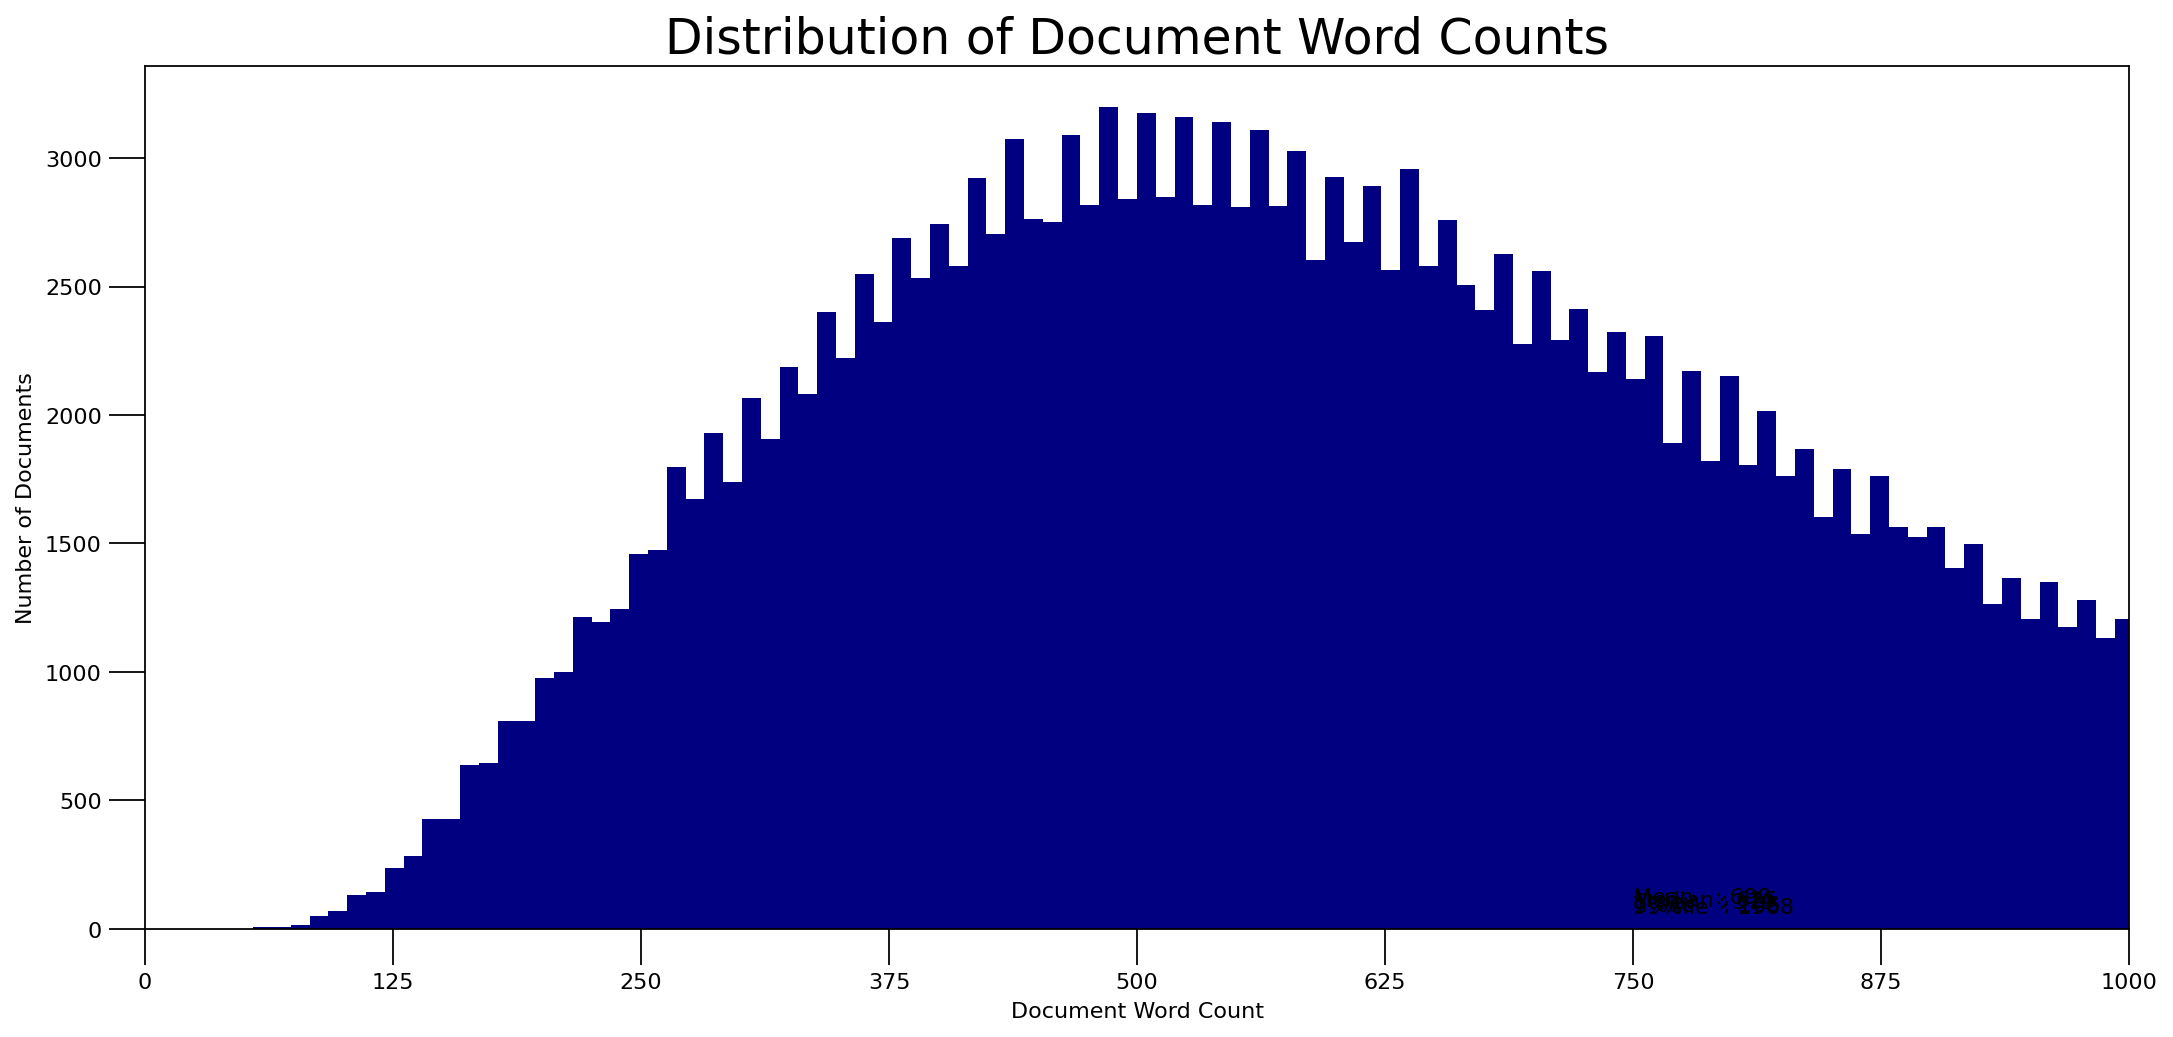

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-62-b63bfb13fca1>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-62-b63bfb13fca1>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-62-b63bfb13fca1>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This

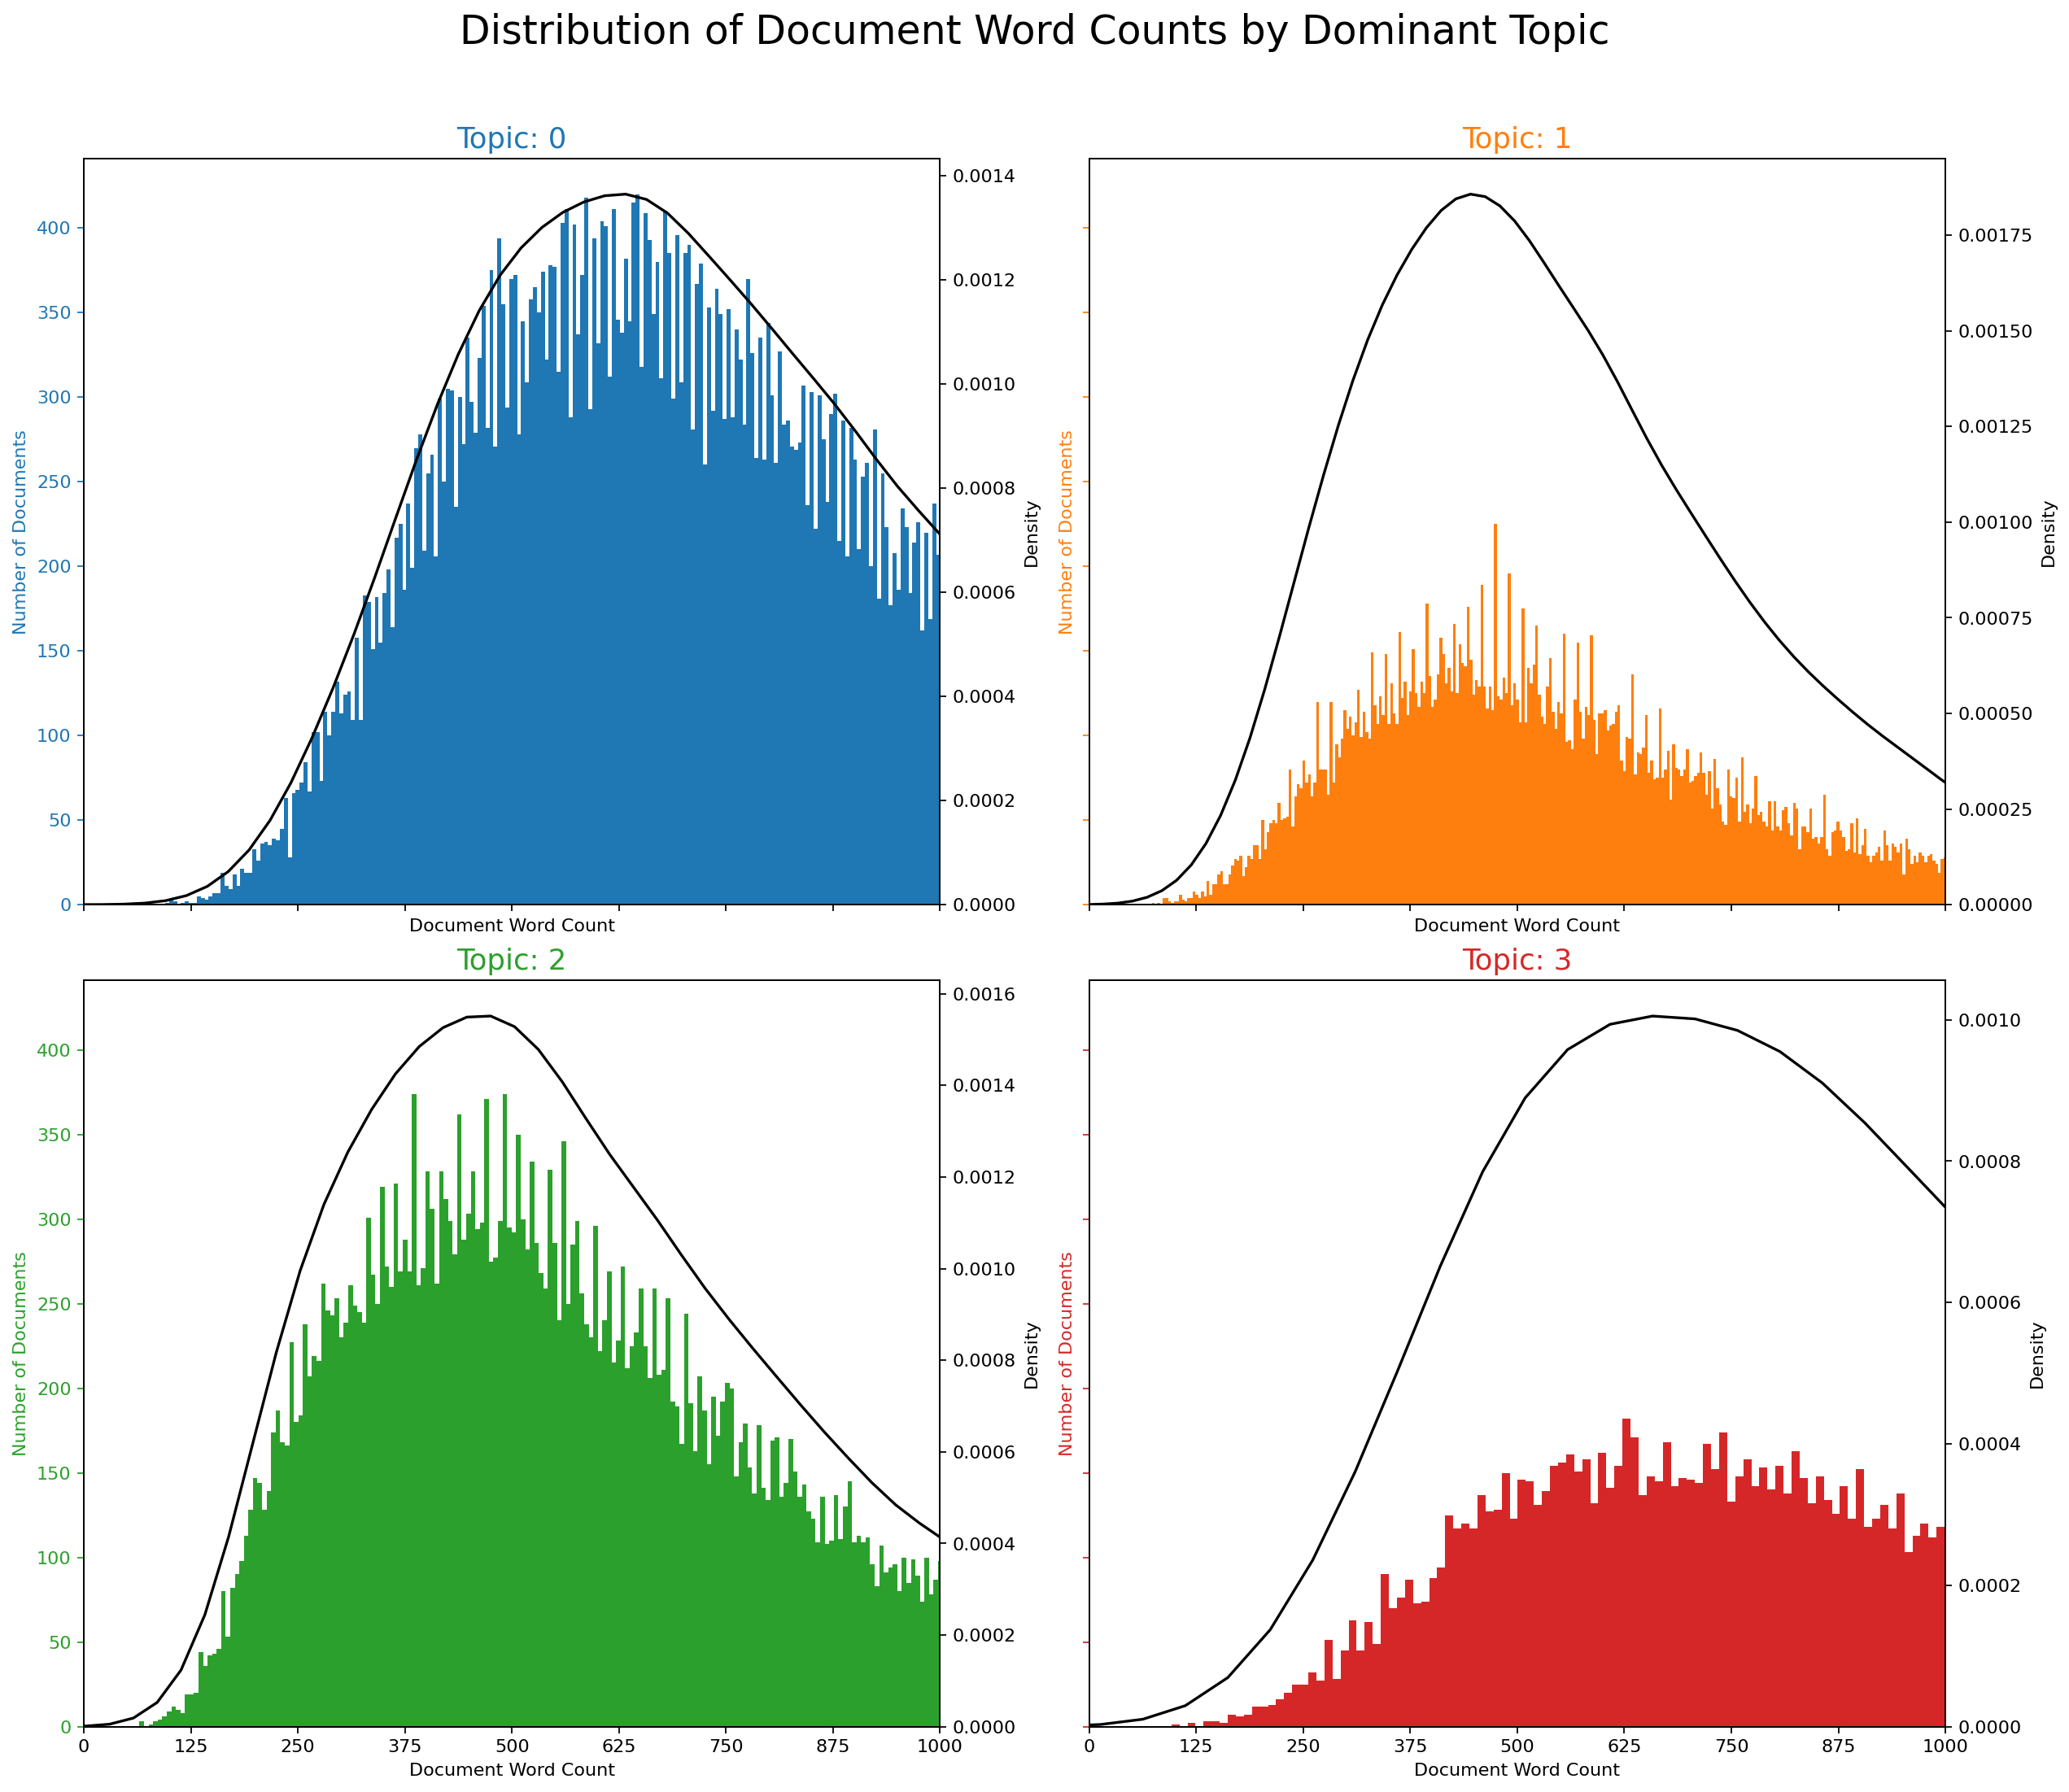

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

Word Clouds of Top N Keywords in Each Topic

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


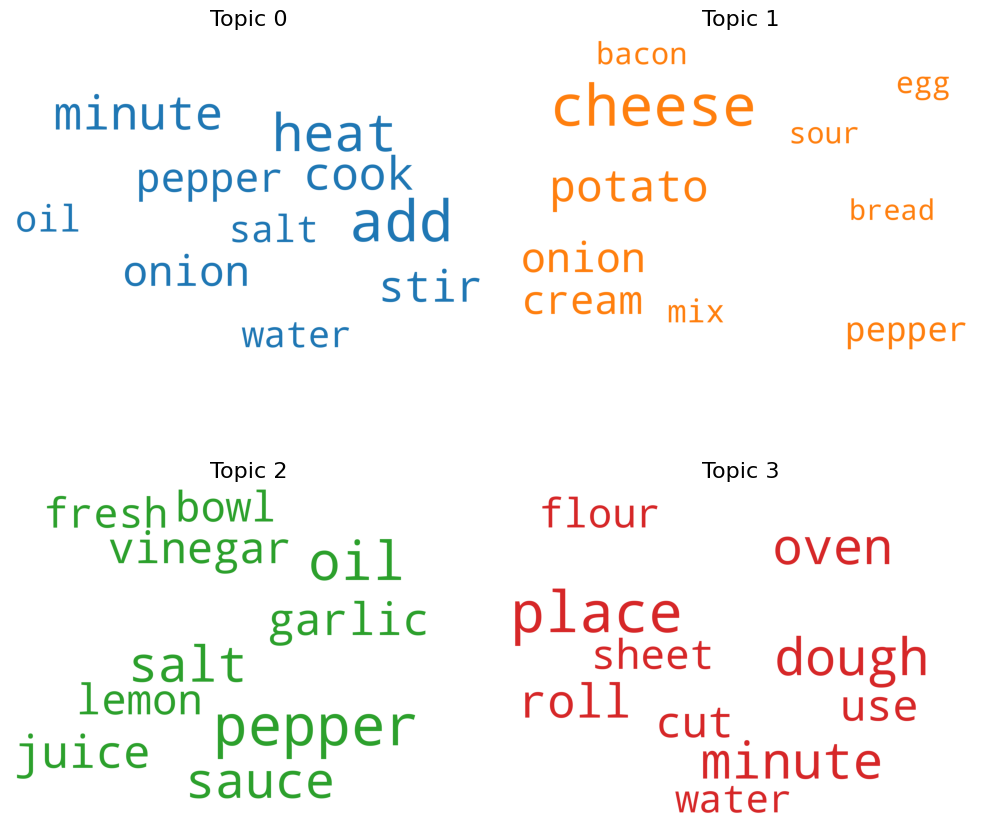

In [ ]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Word Counts of Topic Keywords

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-70-e6e860382769>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


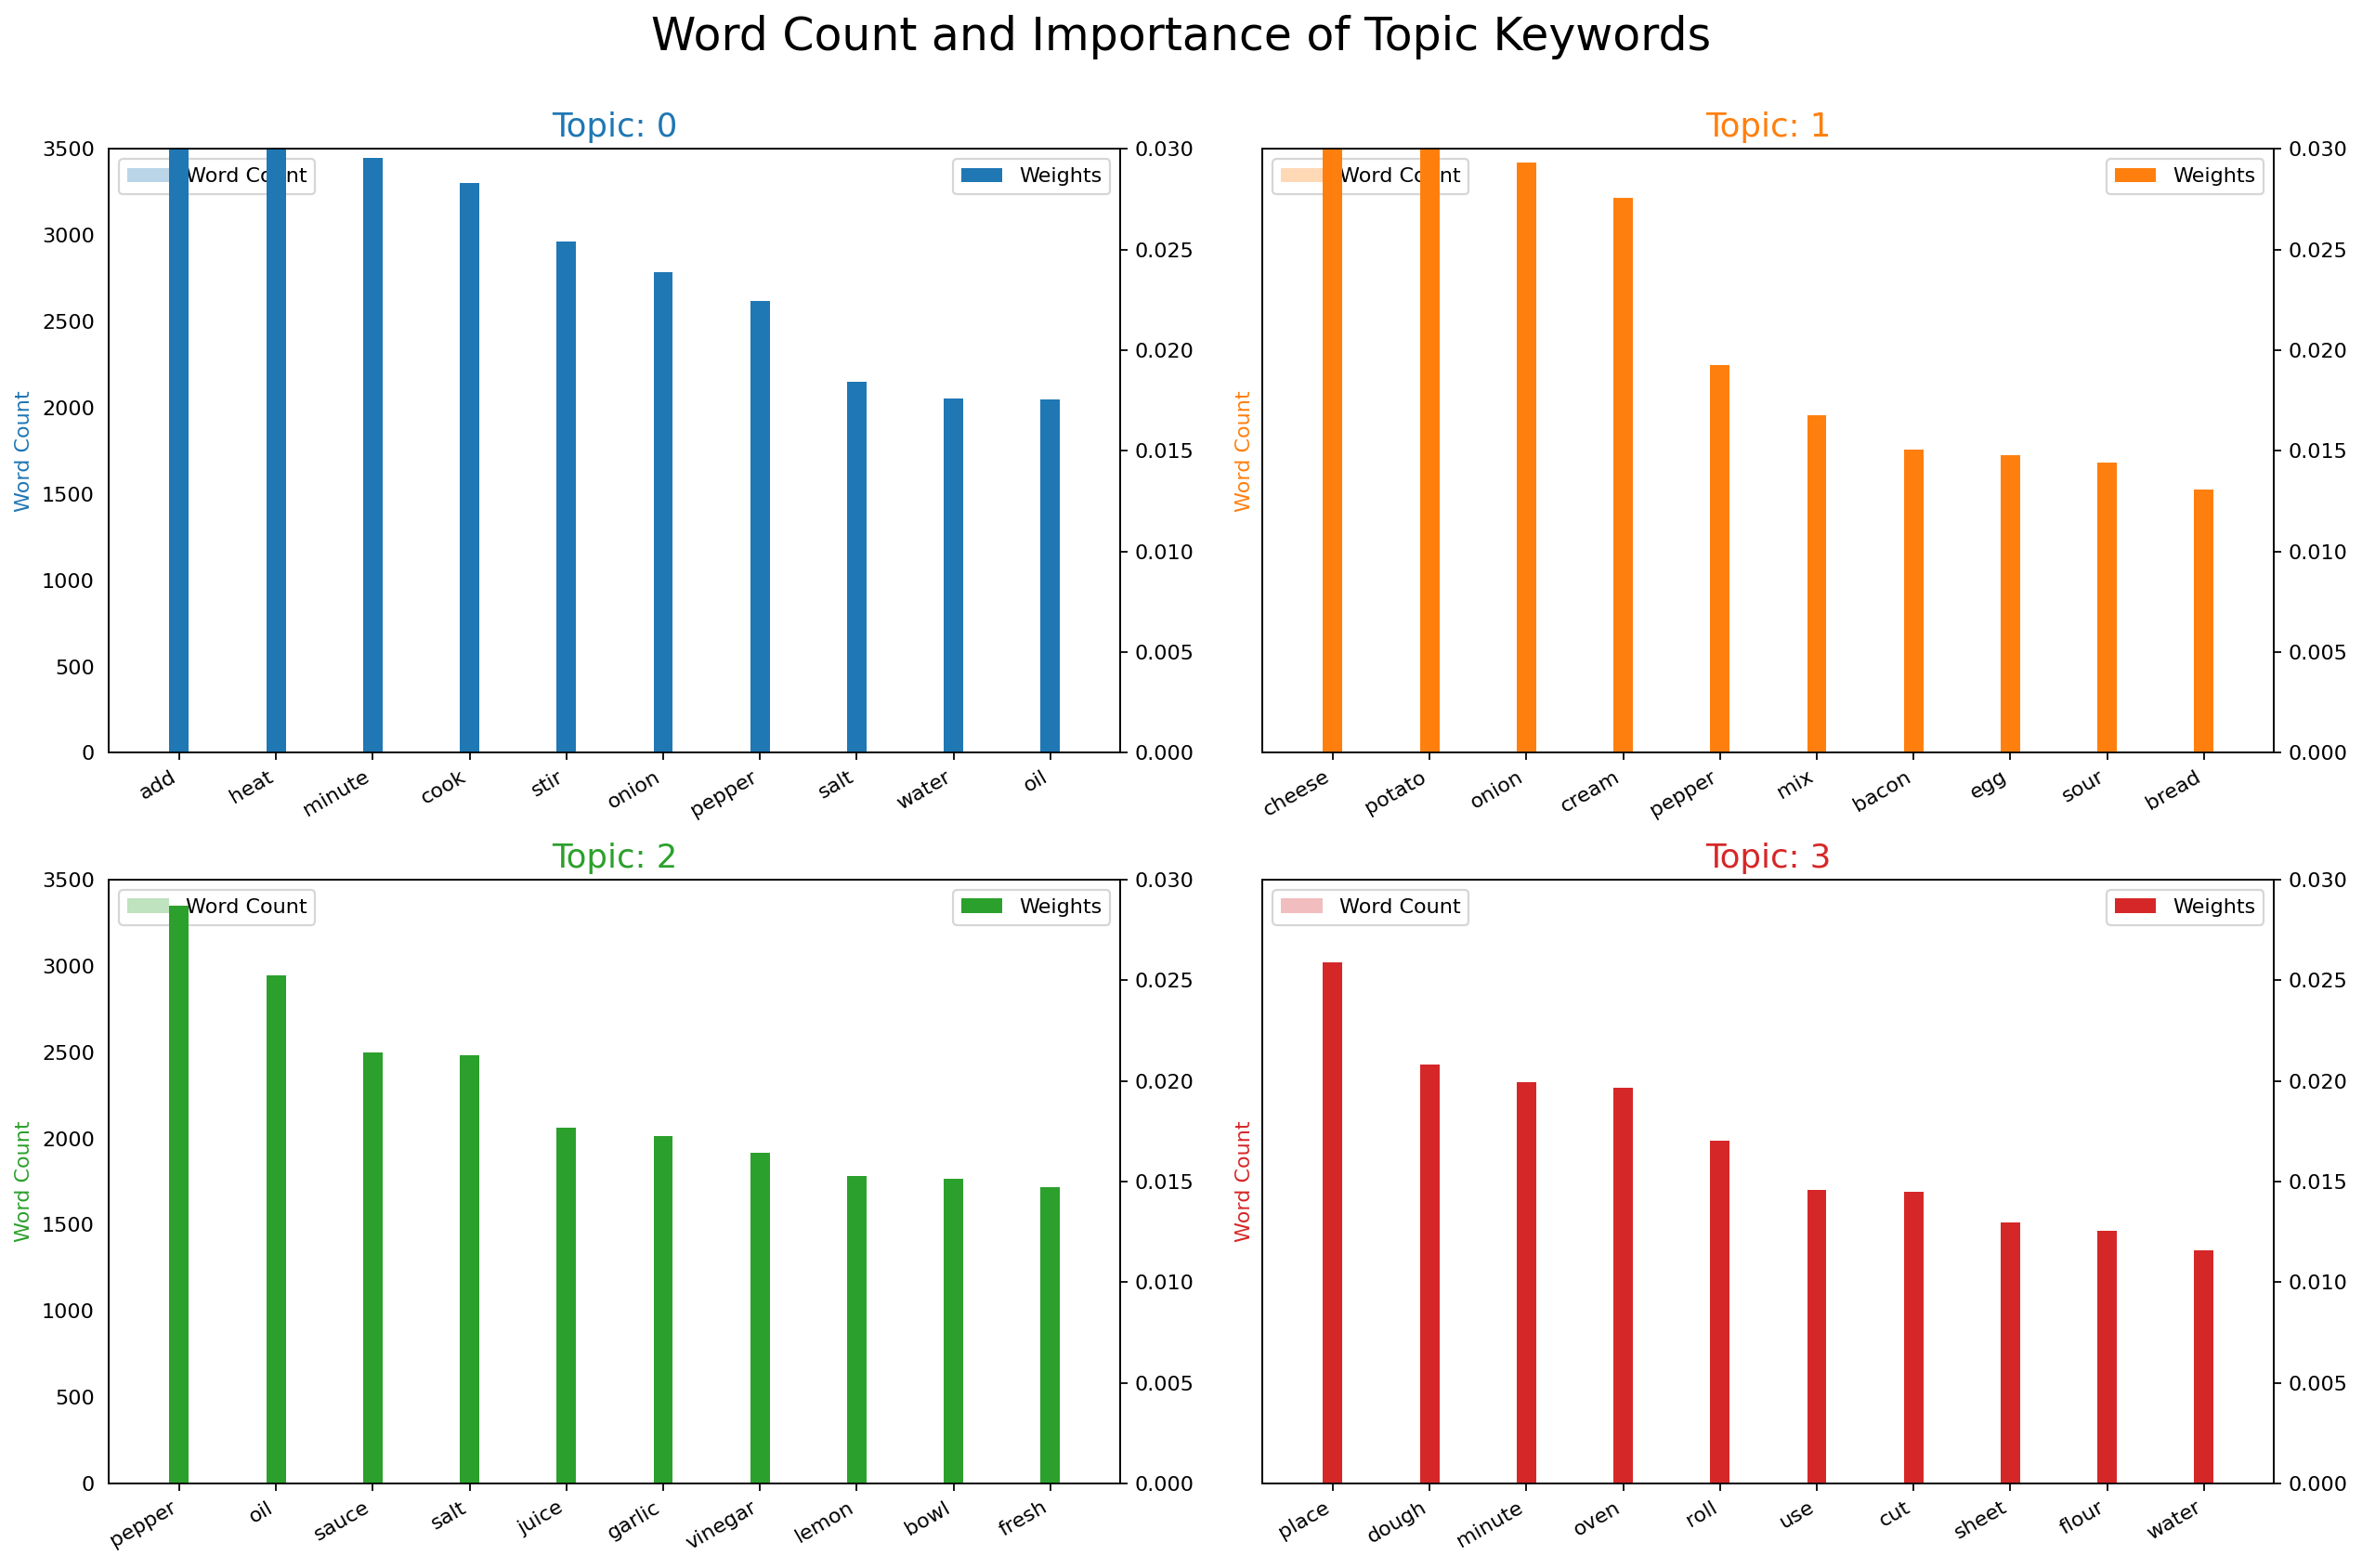

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in recipe_df['tokenised_text'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

Sentence Chart Colored by Topic

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: ignored

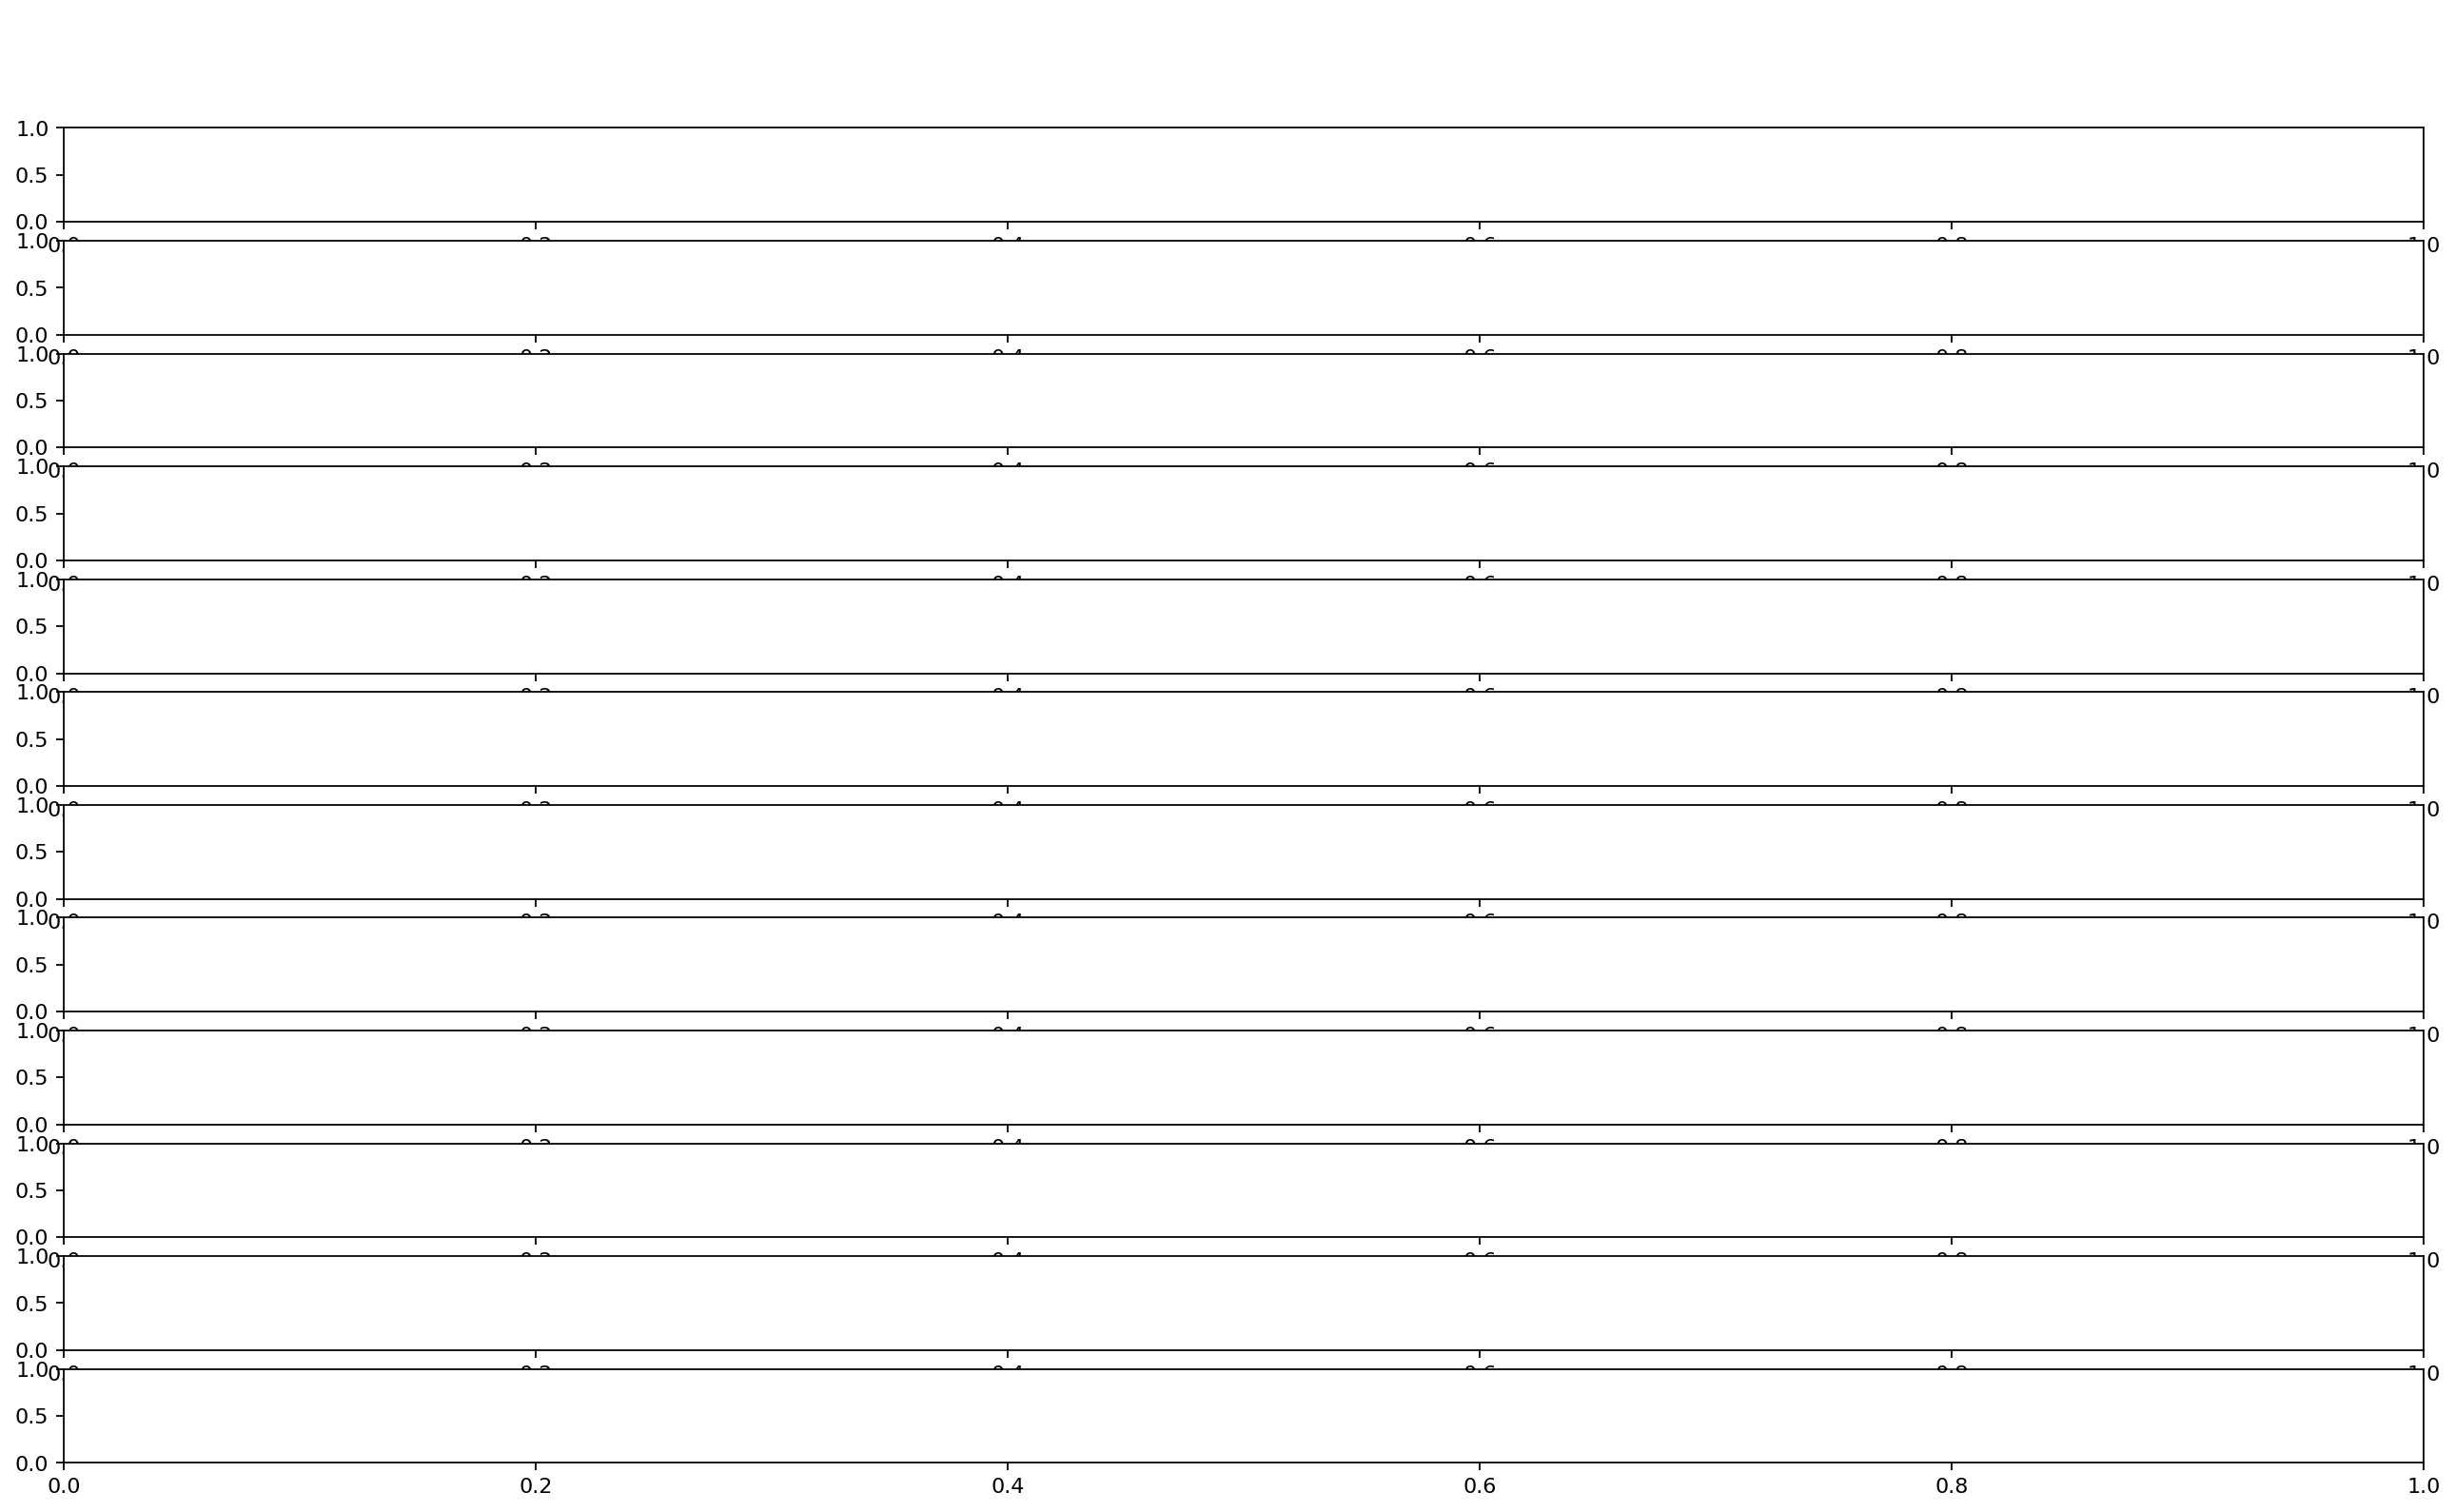

In [ ]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=dtm, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1]
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1,
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

What are the most discussed topics in the documents?

In [ ]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=dtm, end=-1)

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False)
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: ignored

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: ignored

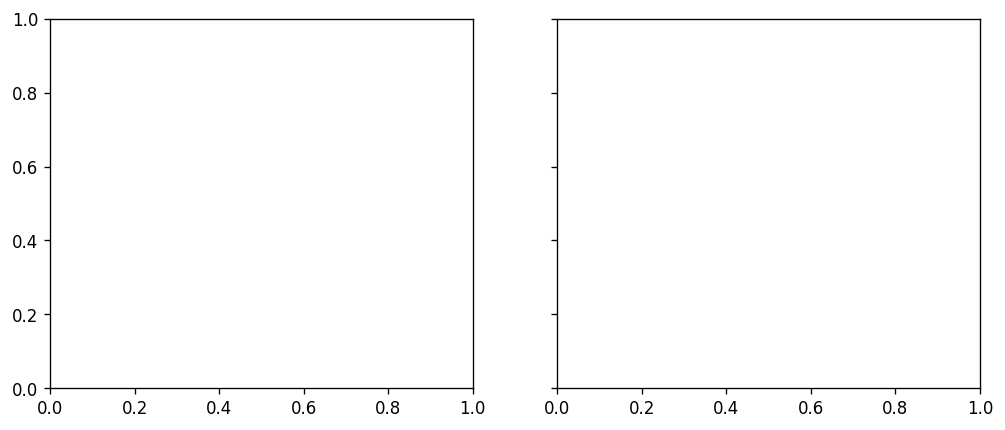

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

t-SNE Clustering Chart

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[dtm]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics),
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: ignored